<a href="https://colab.research.google.com/github/Sumedh-1203/OE5450/blob/main/PINN_Lid_Driven_Cavity1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Neural network architecture for solving Navier-Stokes equations
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 40)
        self.fc4 = nn.Linear(40, 40)
        self.fc5 = nn.Linear(40, 3)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)
        return x

In [20]:
# Define the PDE residuals for the time-dependent Navier-Stokes equations
def ns_residual(model, x, y, Re):
    # Compute the outputs
    u_v_p = model(torch.cat([x, y], dim=1))
    u = u_v_p[:, 0:1]
    v = u_v_p[:, 1:2]
    p = u_v_p[:, 2:3]

    # Compute gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    # Continuity equation
    continuity = u_x + v_y

    # Navier-Stokes equations
    momentum_u = u * u_x + v * u_y + p_x - (1 / Re) * (u_xx + u_yy)
    momentum_v = u * v_x + v * v_y + p_y - (1 / Re) * (v_xx + v_yy)

    return continuity, momentum_u, momentum_v

In [21]:
def boundary_loss(model, xb, yb, ub, vb, x_bl, y_bl, p_bl):
    u_v_p = model(torch.cat([xb, yb], dim=1))
    u_pred = u_v_p[:, 0:1]
    v_pred = u_v_p[:, 1:2]

    # Calculate pressure prediction at the bottom-left corner separately
    p_pred_bl = model(torch.cat([x_bl, y_bl], dim=1))[:, 2:3]

    loss_u = nn.MSELoss()(u_pred, ub)
    loss_v = nn.MSELoss()(v_pred, vb)
    loss_p = nn.MSELoss()(p_pred_bl, p_bl)  # Only consider the bottom-left corner pressure

    return loss_u + loss_v + loss_p

In [22]:
# def initial_condition_loss(model, x, y, t):
#     u_v_p = model(torch.cat([x, y, t], dim=1))
#     u_pred = u_v_p[:, 0:1]
#     v_pred = u_v_p[:, 1:2]
#     p_pred = u_v_p[:, 2:3]

#     loss_u = nn.MSELoss()(u_pred, torch.zeros_like(u_pred))
#     loss_v = nn.MSELoss()(v_pred, torch.zeros_like(v_pred))
#     loss_p = nn.MSELoss()(p_pred, torch.zeros_like(p_pred))

#     return loss_u + loss_v + loss_p

In [23]:
def generate_boundary_data(n):
    # Top boundary (y = 1, u = 1, v = 0)
    x_top = torch.linspace(0, 1, n).reshape(-1, 1)
    y_top = torch.ones_like(x_top)
    u_top = torch.ones_like(x_top)
    v_top = torch.zeros_like(x_top)

    # Bottom boundary (y = 0, u = 0, v = 0)
    x_bottom = torch.linspace(0, 1, n).reshape(-1, 1)
    y_bottom = torch.zeros_like(x_bottom)
    u_bottom = torch.zeros_like(x_bottom)
    v_bottom = torch.zeros_like(x_bottom)

    # Left boundary (x = 0, u = 0, v = 0)
    y_left = torch.linspace(0, 1, n).reshape(-1, 1)
    x_left = torch.zeros_like(y_left)
    u_left = torch.zeros_like(y_left)
    v_left = torch.zeros_like(y_left)

    # Right boundary (x = 1, u = 0, v = 0)
    y_right = torch.linspace(0, 1, n).reshape(-1, 1)
    x_right = torch.ones_like(y_right)
    u_right = torch.zeros_like(y_right)
    v_right = torch.zeros_like(y_right)

    # Bottom-left corner (x = 0, y = 0, p = 1)
    x_bl = torch.tensor([[0.0]])
    y_bl = torch.tensor([[0.0]])
    p_bl = torch.tensor([[1.0]])

    # Combine all boundary points (excluding pressure point for velocities)
    xb = torch.cat([x_top, x_bottom, x_left, x_right], dim=0)
    yb = torch.cat([y_top, y_bottom, y_left, y_right], dim=0)
    ub = torch.cat([u_top, u_bottom, u_left, u_right], dim=0)
    vb = torch.cat([v_top, v_bottom, v_left, v_right], dim=0)

    return xb, yb, ub, vb, x_bl, y_bl, p_bl

In [24]:
def train_pinn(model, optimizer, n_iterations, n_boundary, n_domain, Re, boundary_weight):
    losses = []  # To store loss values for plotting
    for iteration in range(n_iterations):
        optimizer.zero_grad()

        # Boundary loss
        xb, yb, ub, vb, x_bl, y_bl, p_bl = generate_boundary_data(n_boundary)
        loss_boundary = boundary_loss(model, xb, yb, ub, vb, x_bl, y_bl, p_bl)

        # Domain loss (PDE residuals)
        x_domain = torch.rand(n_domain, 1).requires_grad_(True)
        y_domain = torch.rand(n_domain, 1).requires_grad_(True)
        t_domain = 100 * torch.rand(n_domain, 1).requires_grad_(True)
        continuity, momentum_u, momentum_v = ns_residual(model, x_domain, y_domain, Re)
        loss_continuity = torch.mean(continuity ** 2)
        loss_momentum_u = torch.mean(momentum_u ** 2)
        loss_momentum_v = torch.mean(momentum_v ** 2)
        loss_domain = loss_continuity + loss_momentum_u + loss_momentum_v

        # Initial condition loss (at t=0)
        # t_initial = torch.zeros_like(x_domain)
        # loss_initial = initial_condition_loss(model, x_domain, y_domain, t_initial)

        # Total loss
        loss = boundary_weight * loss_boundary + loss_domain
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Store the loss value

        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss.item()}, Loss_D = {loss_domain.item()}, Loss_B = {loss_boundary.item()}")

    return losses

In [25]:
# Plotting the loss function vs epochs
def plot_loss(losses):
    if not losses:
        print("No loss data to plot.")
        return

    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function vs Epochs')
    plt.legend()
    plt.show()

Iteration 0: Loss = 131.68304443359375, Loss_D = 0.003371588420122862, Loss_B = 1.3167967796325684
Iteration 100: Loss = 9.169057846069336, Loss_D = 0.09897414594888687, Loss_B = 0.09070083498954773
Iteration 200: Loss = 7.564807415008545, Loss_D = 0.09858396649360657, Loss_B = 0.0746622309088707
Iteration 300: Loss = 2.986814022064209, Loss_D = 0.25939545035362244, Loss_B = 0.02727418579161167
Iteration 400: Loss = 1.8627691268920898, Loss_D = 0.16381151974201202, Loss_B = 0.01698957569897175
Iteration 500: Loss = 1.4224908351898193, Loss_D = 0.11728304624557495, Loss_B = 0.01305207796394825
Iteration 600: Loss = 1.2139405012130737, Loss_D = 0.10380971431732178, Loss_B = 0.011101308278739452
Iteration 700: Loss = 1.118892788887024, Loss_D = 0.1159893274307251, Loss_B = 0.010029034689068794
Iteration 800: Loss = 1.061630129814148, Loss_D = 0.12580476701259613, Loss_B = 0.009358253329992294
Iteration 900: Loss = 1.0390944480895996, Loss_D = 0.14672568440437317, Loss_B = 0.00892368797212

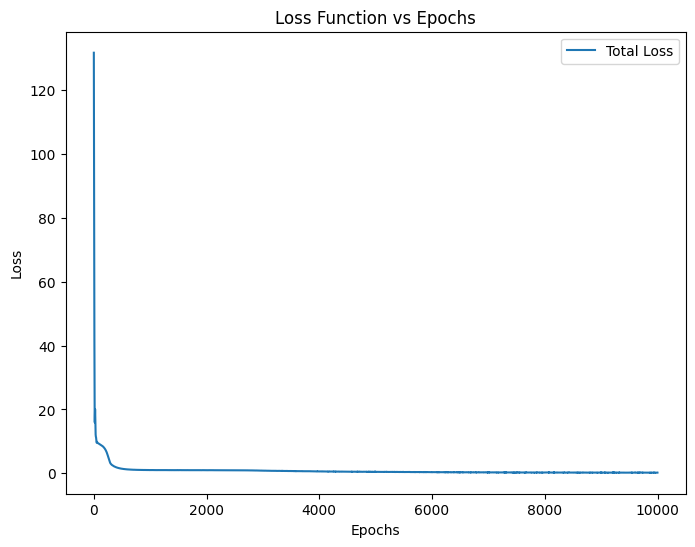

In [27]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Parameters
n_iterations = 10000
n_boundary = 400
n_domain = 10000
Re = 100.0  # Reynolds number
boundary_weight = 100.0  # Increase this weight to enforce boundary conditions more strictly
# initial_weight = 100.0  # Weight for the initial condition loss

# Train the model and plot the loss function
losses = train_pinn(model, optimizer, n_iterations, n_boundary, n_domain, Re, boundary_weight)
plot_loss(losses)

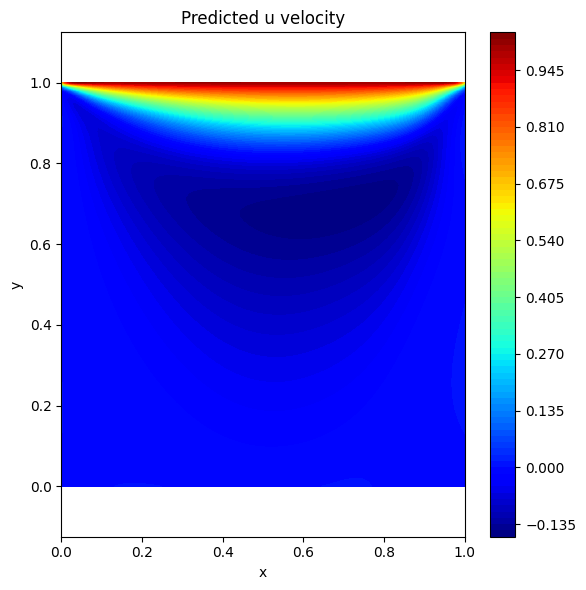

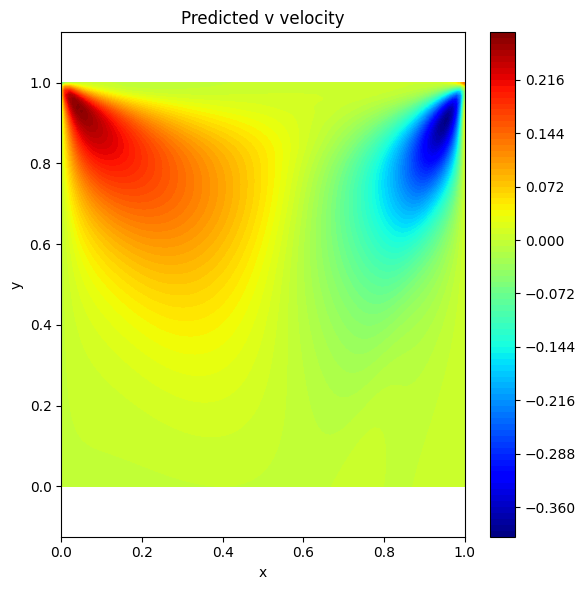

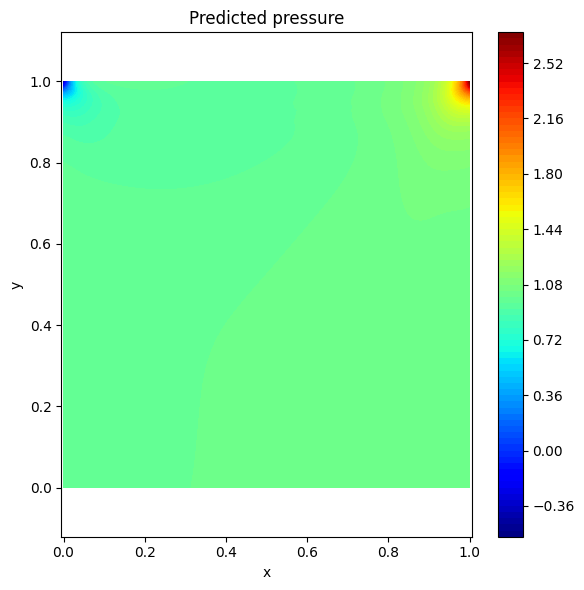

In [30]:
# Function to plot and display the results
def plot_results(model, n_points=100):
    # Create a square domain
    x = torch.linspace(0, 1, n_points).reshape(-1, 1)
    y = torch.linspace(0, 1, n_points).reshape(-1, 1)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze())
    X, Y = X.flatten().reshape(-1, 1), Y.flatten().reshape(-1, 1)

    with torch.no_grad():
        u_v_p = model(torch.cat([X, Y], dim=1))
        u = u_v_p[:, 0].reshape(n_points, n_points).numpy()
        v = u_v_p[:, 1].reshape(n_points, n_points).numpy()
        p = u_v_p[:, 2].reshape(n_points, n_points).numpy()

    X, Y = X.reshape(n_points, n_points).numpy(), Y.reshape(n_points, n_points).numpy()

    # Plot and display the predicted u velocity
    plt.figure(figsize=(6, 6))
    cf1 = plt.contourf(X, Y, u, cmap='jet', levels=100)
    plt.colorbar(cf1)
    plt.title('Predicted u velocity')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')  # Ensure the axes are equal
    plt.tight_layout()
    plt.show()

    # Plot and display the predicted v velocity
    plt.figure(figsize=(6, 6))
    cf2 = plt.contourf(X, Y, v, cmap='jet', levels=100)
    plt.colorbar(cf2)
    plt.title('Predicted v velocity')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')  # Ensure the axes are equal
    plt.tight_layout()
    plt.show()

    # Plot and display the predicted pressure
    plt.figure(figsize=(6, 6))
    cf3 = plt.contourf(X, Y, p, cmap='jet', levels=100)
    plt.colorbar(cf3)
    plt.title('Predicted pressure')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')  # Ensure the axes are equal
    plt.tight_layout()
    plt.show()

plot_results(model)